# Fig 1: oscillation presence gif

This notebook creates an animated visualizer showing how filtered aperiodic activity can look rhythmic. 

Based on Fig 1 (b & c) of the oscillation methods paper. 

ToDo:
- figure out issue with size of ax1

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

from fooof import Bands

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import create_times
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum, trim_spectrum

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Import custom code
from code.utils import yield_sig
from code.plts import plot_timeseries, plot_spectra, plot_bar
from code.gif import clear_output, _gif_plot_output

## SETTINGS

In [4]:
# Define band definitions
BANDS = Bands({'delta' : [2, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]})

# Define band colors, for shading
BAND_COLORS = {'delta' : '#e8dc35',
               'theta' : '#46b870',
               'alpha' : '#1882d9',
               'beta'  : '#a218d9',
               'gamma' : '#e60026'}

shade_colors = [BAND_COLORS[band] for band in BANDS.labels]

In [15]:
xlim = [2, 30]

## DEFINE AXES

In [16]:
def make_axes():
    
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    gs = fig.add_gridspec(8, 2)
    
    ax1 = fig.add_subplot(gs[0:3, 0])
    ax2 = fig.add_subplot(gs[3:, 0])
    ax3 = fig.add_subplot(gs[0:2, 1])
    ax4 = fig.add_subplot(gs[2:4, 1])
    ax5 = fig.add_subplot(gs[4:6, 1])
    ax6 = fig.add_subplot(gs[6:, 1])
    
    return fig, ax1, ax2, [ax3, ax4, ax5, ax6]

## SIMULATE SIGNAL

In [17]:
# Settings
n_seconds = 100
fs = 1000
exp = -1
ap_range = (1.5, None)

In [18]:
sig = sim_powerlaw(n_seconds, fs, exp, ap_range)
times = create_times(n_seconds, fs)

## EXAMPLE PLOT

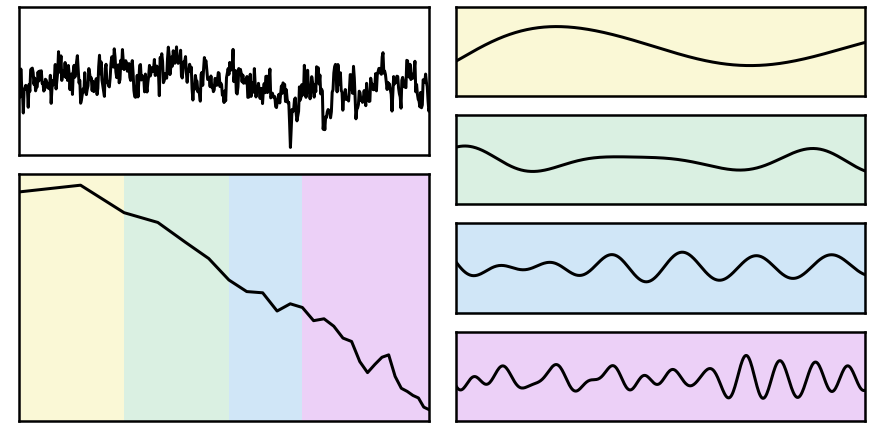

In [19]:
# Create an example image for the visualizer
fig, ax1, ax2, filt_axes = make_axes()
plot_timeseries(sig, xlim=[2000, 2500], colors='black', ax=ax1)
plot_spectra(*trim_spectrum(*compute_spectrum(sig, fs), xlim), colors='black',
             shade_ranges=BANDS.definitions, shade_colors=shade_colors,
             xlim=list(np.log10(xlim)), ax=ax2)
for (label, f_range), shade, ax in zip(BANDS, shade_colors, filt_axes):
    filt_trace = filter_signal(sig, fs, 'bandpass', f_range)
    plot_timeseries(filt_trace, shade=shade, xlim=[2000, 2500], colors='black', ax=ax)

## BUILDER FUNCTION

In [20]:
def build_all(sig, sleep=0.01, n_build=100, save=False):
    
    ## Setup
    # yielder settings
    size = 500
    step = 5
    start = 5000
    
    sig_yielder = yield_sig(sig, start=start, size=size, step=step)
    
    # Pre create filtered signals
    filts = {}
    for label, f_range in BANDS:
        filt_trace = filter_signal(sig, fs, 'bandpass', f_range)
        filts[label] = yield_sig(filt_trace, start=start, size=size, step=step)
        
    ## Create builds
    for b_ind in range(n_build):
        
        clear_output(wait=True)
        fig, ax1, ax2, filt_axes = make_axes()
        
        cur_sig = next(sig_yielder)
        plot_timeseries(cur_sig, colors='black', ax=ax1)
        
        spect_sig = sig[start + step * b_ind-5000:start + step * b_ind+5000]
        freqs, powers = trim_spectrum(*compute_spectrum(spect_sig, fs=fs), xlim)
        plot_spectra(freqs, powers, colors='black', 
                     shade_ranges=BANDS.definitions, shade_colors=shade_colors,
                     xlim=list(np.log10(xlim)), ax=ax2)
        
        for ax, shade, (label, filt_yielder) in zip(filt_axes, shade_colors, filts.items()):
            plot_timeseries(next(filt_yielder), shade=shade, colors='black', ax=ax)
        
        _gif_plot_output(fig, save, b_ind, 'fig1', sleep)

## ANIMATED PLOT

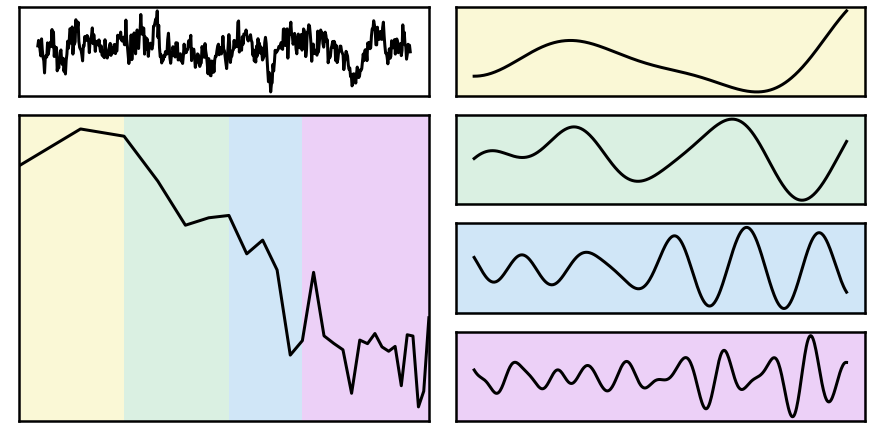

In [21]:
build_all(sig, save=False)